<a href="https://colab.research.google.com/github/ariameetgit/practical-python/blob/main/COM4509_lab3_(2023_24).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision trees and ensemble methods

A [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning) can be thought of as a sequence of **hierarchical if-else statements** that test feature values to predict a class.


In this notebook we will explore the use of [scikit-learn](https://scikit-learn.org/stable/) for Decision Trees. This first example will allow us to understand some of the parameters in a decision tree.


## Decision trees with scikit-learn

We will build a classifier that will be able to detect spam from the text in an email. We'll use the  [Spambase Dataset](http://archive.ics.uci.edu/ml/datasets/Spambase) from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php).

The dataset contains 57 features related to word frequency, character frequency, and others related to capital letters. The description of the features and labels in the dataset is available [here](http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names). The output label indicates whether an email was considered 'ham' or 'spam', so it is a binary label (1=spam).

We will use Decision trees as our predictive model. But first, we need to get the data and the names of the attributes:

In [1]:
import pandas as pd
import numpy as np
spam_data = pd.read_csv('https://docs.google.com/uc?export=download&id=1nQVmHSzBLhMschMsAO4aZMhIgfW7qu-_', header=None)
spam_names_list = pd.read_csv('https://docs.google.com/uc?export=download&id=1GgLZoUqyVGO21h5Iso30tOXwNBloVU4T', header=None, delimiter=":")
spam_names = spam_names_list[0]
spam_data.columns = spam_names
X = spam_data.iloc[:, 0:57]
y = spam_data.iloc[:, 57]

In [ ]:
spam_data.describe()

### Visualising decision trees

To demonstrate the classifier, we keep things simple for now and use the whole dataset.

In [2]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf = clf.fit(X, y)

In [3]:
clf

DecisionTreeClassifier(criterion='entropy', max_depth=3)

From lectures you'll remember that `criterion='entropy'` means that we are looking to maximise information gain. Having a `max_depth=3` can help reduce overfitting.

To visualize the tree, we can use the [Graphviz](http://www.graphviz.org/) package and use the exporter [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz). It is installed by default on colab. If you need to install the package use (on the commandline):

`conda install python-graphviz`

or, if there are errors, you could try with `pip` instead:

`pip install graphviz`

In [4]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)

#If you want to export the tree as a pdf file, use:
#graph.render("spam")
#If you're using colab, you need to click on the "Files" button on the left-hand toolbar. You'll then be able to see `spam.pdf`.

We can draw the graph with:

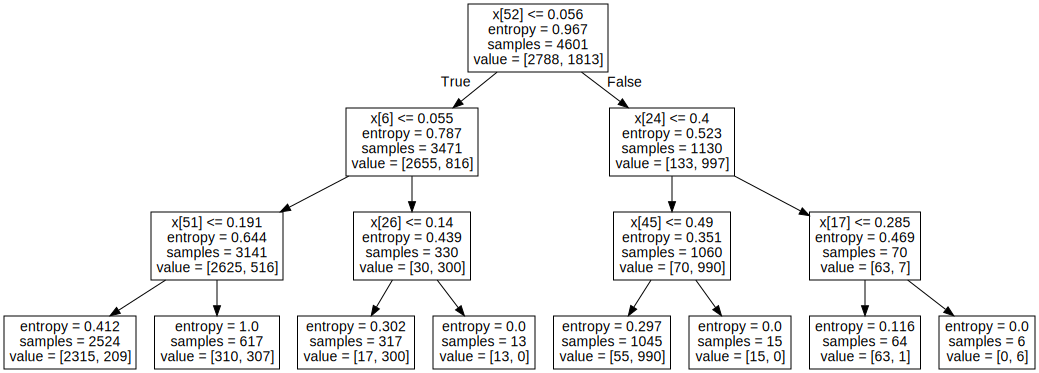

In [5]:
graph

Notice how the entropy varies as you go down the tree.

We can use the [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz) to customize several aspects of the tree. For example, if you look at the .pdf file generated, the names of the features are assigned by default by refering to the column index in `X`. It is possible to assign the names of the features directly. Likewise for the labels `y`.

In [6]:
dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=spam_names[0:57],
                      class_names=['ham', 'spam'],
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)

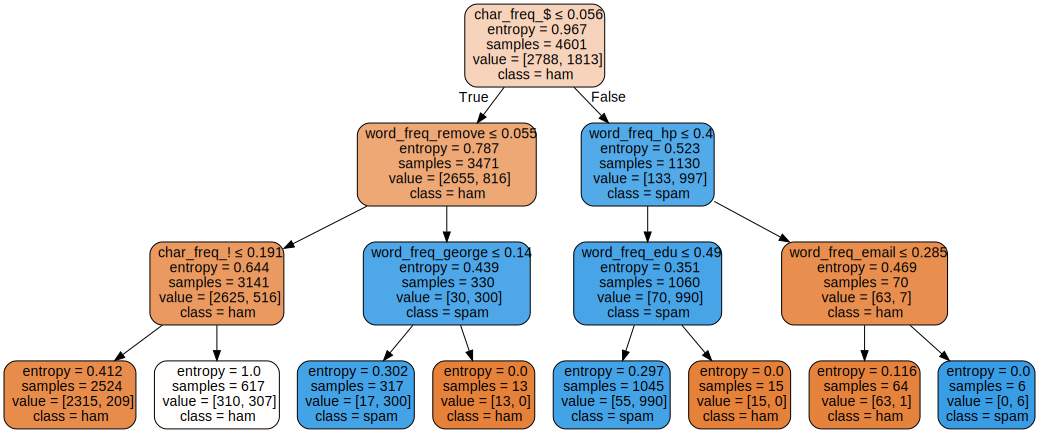

In [7]:
graph

One could quickly use the tree generated for the purposes of [feature selection](https://en.wikipedia.org/wiki/Feature_selection). Feature selection is a whole research area in machine learning with a very practical purpose: being able to identify which features are more relevant in a prediction problem. In modern big data applications, the amount of features generated is huge. For example, one could extract thousands of millions of features from a genome sequence that maps to a particular medical disorder. Finding which features are more relevant for correctly classifying the disorder could lead to breakthroughs in medicine.

Relevant features can be identified starting from the top level of the tree and going down to the leaf nodes. For example, one can argue that the most important feature is the one used in the root node (e.g. char_freq_$ for the Spambase dataset) since it has the highest entropy.    

## Evaluating the prediction ability of a decision tree classifier

We will now evaluate the predictive ability of the decision tree classifier on a subset of the Spam dataset. The Decision Tree has several tunable parameters, including, the criterion or impurity measure (criterion) and the maximum depth of the tree (max_depth). A complete list of parameters for the DecisionTreeClassifier implemented in scikit-learn can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

We will create a simple Grid Search for finding the best parameters for our model.

In [8]:
# We first split the data into a train and a test set.
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
indexes = list(ss.split(X, y))
train_set  = indexes[0][0]
test_set  = indexes[0][1]
Xtrain = X.iloc[train_set, :]
ytrain = y.iloc[train_set]
Xtest = X.iloc[test_set, :]
ytest = y.iloc[test_set]

We now create a Grid search for the parameters criterion and max_depth and we use the training data to find the best parameters

In [9]:
from sklearn.model_selection import GridSearchCV # For model selection
criterion_opts = np.array(['entropy', 'gini'])
max_depth_opts = [3, 5, 10, 15]
param_grid = dict(criterion = criterion_opts, max_depth = max_depth_opts)
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': array(['entropy', 'gini'], dtype='<U7'),
                         'max_depth': [3, 5, 10, 15]},
             scoring='accuracy')

We can see now which ones were the best parameters.

In [10]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 15}

We then train a new decision tree using those parameters and then evaluate the model on the test set.

In [11]:
clf = tree.DecisionTreeClassifier(criterion=grid.best_params_["criterion"],max_depth=grid.best_params_["max_depth"])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

We now evaluate the accuracy

In [12]:
from sklearn.metrics import accuracy_score # Accuracy score
accuracy = accuracy_score(ytest, ypred)
print(accuracy)

0.9138305575669804


### Distribution of the labels

Let us look at the distribution of the instances for class in the original dataset and in the training data.

>**Warning for MAC OS users** As of today, the current installation of `graphviz` **may** put its own version of freetype into the default python runtime library path. However, matplotlib needs a different version of the same library. The fix is explained in [this entry of stackoverflow](https://stackoverflow.com/questions/28028786/matplotlib-error-libfreetype-6-dylib).

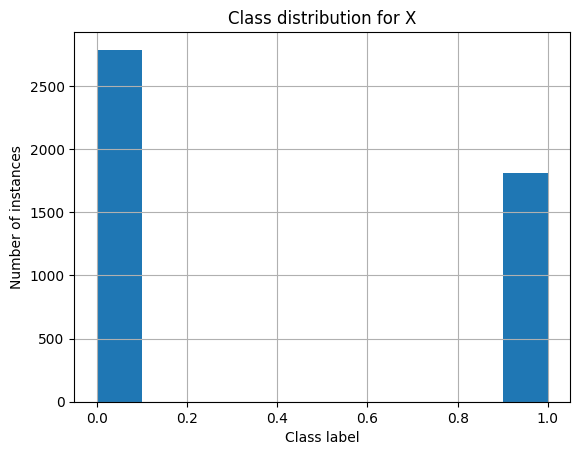

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
y.hist()
plt.ylabel('Number of instances')
plt.xlabel('Class label')
plt.title('Class distribution for X')
plt.show()

Notice that the numbers of data observations per class are different. We usually refer to this kind of problems as "imbalanced".

Bear in mind that when creating your training data, you need to account for this imbalance and be aware against misleading results. For example, accuracy is probably not a good metric to measure performance in these problems:

> If you have 99% of your data in one class, and 1% in a second class. A simple classifier (that reports the first class for all test points) will get about 99% accuracy. Many classifiers might end up just reporting the majority class.

There are different [strategies for balancing a dataset](https://books.google.co.uk/books/about/Imbalanced_Learning.html?id=YqQJngEACAAJ&redir_esc=y) but if for some reason you are not able to balance it, it is important to be aware of these issues. Some stategies include: i) under-sampling the majority class(es), ii) over-sampling the minority class, and iii) combining over- and under-sampling. The python package [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn#id22) has several implementations of these different strategies. You can install the package and try some of them.

### Question 1

A simple strategy we can use to balance the problem for the Spam dataset is to under-sample the majority class. Repeat the spam prediction problem above but make sure you have the same number of samples in both classses.
Do you notice any difference in the accuracy over the same test set that we used before? Also, use a performance measure that takes into account imbalanced data. Do you see any difference between this new performance measure before and after balancing the classes?

In [33]:
# Provide your answer here
# under_sample the majoruty class ,

import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

rus = RandomUnderSampler(sampling_strategy= 0.7)
X_resampled, y_resampled = rus.fit_resample(Xtrain, ytrain)

# split the data
X_retrain, X_reval, y_retrain, y_reval =train_test_split(X_resampled, y_resampled, test_size =0.25)

#train a machine learning model
clf = RandomForestClassifier()
clf.fit(X_resampled, y_resampled)

y_pred_reval = clf.predict(X_reval)
accuracy = np.sum(y_pred_reval == y_reval) / len(y_reval)
print ('Accuracy on validation set:', accuracy)


Accuracy on validation set: 1.0


In [34]:
# repeat the predi


#we've not looked much at the problem of assessing quality of a classifier in imbalanced data...
# quick note, ROC (area under the curve) can be good - but also can be affected by imbalanced data. Precision-recall curves can help.
# also consider f1-score.

## Decision trees for regression

The main difference between Decision Tress for Classification and Decision Trees for Regression is in the impurity measure used. The [decision trees for regression implemented in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) uses the mean squared error by default as the impurity measure. The mean squared error is closely related with the variance, the impurity measure we introduced in the Session for this week.

We are going to go back to the dataset of Bike rentals that we used in Lab 2 and compare the performance of the decision tree for regression over the same partitions of train, validation and test sets that we used back there for the linear regression model

In [35]:
import urllib.request
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv', './SeoulBikeData.csv')
bike_sharing_data = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')
bike_sharing_data = bike_sharing_data.drop('Date', axis=1)
# We transform the int64 variables in the dataset to float64.
for col in ['Rented Bike Count', 'Hour', 'Humidity(%)', 'Visibility (10m)']:
    bike_sharing_data[col] = bike_sharing_data[col].astype('float64')

We split the data into train and test sets. Have a look at the random_state. We use the same number from Lab 2 to make sure the splits into train and test are the same.

In [105]:
from sklearn.model_selection import train_test_split
bs_train_set, bs_test_set = train_test_split(bike_sharing_data, test_size=0.15, random_state=42)
print(bs_train_set)

      Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
5852             1441.0  20.0             34.5         62.0               2.8   
7568             1996.0   8.0              6.0         64.0               1.1   
5970             1956.0  18.0             32.8         63.0               1.3   
6791              941.0  23.0             21.2         56.0               2.5   
576               160.0   0.0             -0.6         64.0               2.4   
...                 ...   ...              ...          ...               ...   
5734             1507.0  22.0             29.9         74.0               2.0   
5191              828.0   7.0             23.5         90.0               0.5   
5390              999.0  14.0             29.5         62.0               2.7   
860               322.0  20.0             -3.4         51.0               1.1   
7270             1501.0  22.0             19.3         55.0               0.5   

      Visibility (10m)  Dew

We perform the same data preprocessing step for the input features

In [42]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

attributes_cat = ['Seasons', 'Holiday', 'Functioning Day']
attributes_num = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', \
                  'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']


# 这里的num 指的是与数据相关的数据，而cat则是一些可以用分类表达的内容，比如week, season , holiday
full_transform = ColumnTransformer([
    ("num", StandardScaler(), attributes_num),
    ("cat", OneHotEncoder(), attributes_cat),
])


We further create a train and a validation set from the original train set

In [ ]:
bs_train2_set, bs_val_set = train_test_split(bs_train_set, test_size=0.15, random_state=42)
bs_train2_set_attributes = bs_train2_set.drop('Rented Bike Count', axis=1)
bs_train2_set_labels = bs_train2_set['Rented Bike Count']
bs_val_set_attributes = bs_val_set.drop('Rented Bike Count', axis=1)
bs_val_set_labels = bs_val_set['Rented Bike Count']

We fit transform the attributes in the train set and transform them in the validation set

In [46]:
# fit transform in the train set
bs_train2_set_attributes_transformed = full_transform.fit_transform(bs_train2_set_attributes)
# transform in the validation set
bs_val_set_attributes_transformed = full_transform.transform(bs_val_set_attributes)

Since we want to perform a GridSearchCV on the same validation data that we used for Lab 2, we will use [`PredefinedSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html#sklearn.model_selection.PredefinedSplit) to tell the cross validator which instances to use for training and which ones for validation. We create first a test_fold array of the same dimensionality than the original training data and assign the value of -1 to the indexes corresponding to train instances and 0 to the indexes corresponding to validation instances. We will then stack the input attributes for both sets and also stack the labels.

In [48]:
from sklearn.model_selection import PredefinedSplit
test_fold = np.zeros((np.shape(bs_train_set)[0], 1))
test_fold[0:np.shape(bs_train2_set)[0]] = -1
ps = PredefinedSplit(test_fold)

We concatenate the attributes and the labels

In [49]:
whole_train_set_attributes = np.vstack((bs_train2_set_attributes_transformed , bs_val_set_attributes_transformed))
whole_train_set_labels = np.hstack((bs_train2_set_labels, bs_val_set_labels))

We can now apply the decision tree for regression and explore different maximum depth options

In [50]:
max_depth_opts = [3, 5, 10, 15]
param_grid = dict(max_depth = max_depth_opts)
grid_regression = GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid, cv=ps, scoring='neg_mean_squared_error')
grid_regression.fit(whole_train_set_attributes, whole_train_set_labels)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 5, 10, 15]},
             scoring='neg_mean_squared_error')

Let us train now a decision tree regressor using the best value for the max depth

In [52]:
regr = tree.DecisionTreeRegressor(max_depth=grid_regression.best_params_["max_depth"], random_state=42)
regr.fit(bs_train2_set_attributes_transformed, bs_train2_set_labels)
bs_val_set_predictions = regr.predict(bs_val_set_attributes_transformed)

And now we compute the RMSE for the validation dataset

In [53]:
from sklearn.metrics import mean_squared_error
error_mod = np.sqrt(mean_squared_error(bs_val_set_labels, bs_val_set_predictions))
error_mod

271.71631148738953

We notice how this is a great improvement compared to the result obtained using linear regression in Lab Notebook 2.

### Question 2

Decision trees do not require any scaling of the features. Use the same splits of the data than before but use the numerical features as they come, this is, do not use StandardScaler() for the numerical features. What is the RMSE on the validation data?

In [100]:
# Provide your answer here
bs_train3_set, bs_val3_set = train_test_split(bs_train_set, test_size=0.15, random_state=42)
bs_train3_set_attributes = bs_train3_set.drop('Rented Bike Count', axis=1)
bs_train3_set_labels = bs_train3_set['Rented Bike Count']
bs_val3_set_attributes = bs_val3_set.drop('Rented Bike Count', axis=1)
bs_val3_set_labels = bs_val3_set['Rented Bike Count']

In [71]:
# # fit transform in the train set
# bs_train2_set_attributes_transformed = full_transform.fit_transform(bs_train2_set_attributes)
# # transform in the validation set
# bs_val_set_attributes_transformed = full_transform.transform(bs_val_set_attributes)

In [101]:
from sklearn.model_selection import PredefinedSplit
test_fold = np.zeros((np.shape(bs_train_set)[0], 1))
test_fold[0:np.shape(bs_train3_set)[0]] = -1
ps = PredefinedSplit(test_fold)

In [102]:
whole_train_set_attributes = np.vstack((bs_train3_set_attributes , bs_val3_set_attributes))
whole_train_set_labels = np.hstack((bs_train3_set_labels, bs_val3_set_labels))

In [96]:
max_depth_opts = [3, 5, 10, 15]
param_grid = dict(max_depth = max_depth_opts)
grid_regression = GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid, cv=ps, scoring='neg_mean_squared_error')
grid_regression.fit(whole_train_set_attributes, whole_train_set_labels)

ValueError: ignored

In [97]:
regr = tree.DecisionTreeRegressor(max_depth=grid_regression.best_params_["max_depth"], random_state=42)
regr.fit(bs_train2_set_attributes_transformed, bs_train2_set_labels)
bs_val_set_predictions = regr.predict(bs_val_set_attributes_transformed)

AttributeError: ignored

In [98]:
from sklearn.metrics import mean_squared_error
error_mod = np.sqrt(mean_squared_error(bs_val_set_labels, bs_val_set_predictions))
error_mod

271.71631148738953

## Ensemble learning

In machine learning, we use the term ensemble model to refer to a predictive model that is a composition of several other predictive models. For example, for a classification problem, we can have an ensemble of three classifiers, where the first of them is a decision tree classifier, the second one is a logistic regressor (to be studied in Session 6) and the third one is a shallow neural network. We can train all classifiers with the same training data and then, at test time, predictions can be done using majority voting.

Ensemble methods are very popular since they usually show higher performance when compared to simpler classifiers. In fact, gradient boosting trees are the most popular method in [**Kaggle**](https://www.kaggle.com/), a platform that hosts data science competitions. The top entry in the [**Netflix Prize**](https://en.wikipedia.org/wiki/Netflix_Prize) Competition, one of the most famous data science competitions, was based on an ensemble predictive model.

The most commmon ensemble methods use decision trees as the members of the ensemble. Scikit-learn implemenst two types of Tree Ensembles, random forests and gradient boosting. The main difference between both methods is the way in which they combine the different trees that compose the ensemble.

### Random Forests

The tree ensemble in random forests is built by training individual decision trees on different subsets of the training data and using a subset of the available features. For classification, the prediction is done by majority voting among the individual trees. In fact, according to Scikit-learn documentation for the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) "The predicted class of an input sample is a vote by the trees in the forest, weighted by their probability estimates. That is, the predicted class is the one with highest mean probability estimate across the trees." For regression, the prediction is the average of the individual predictions of each tree.

Some of the additional parameters required in the Random Forest implementation in Scikit-learn include

> **n_estimators** the total number of trees to train<p>
**max_features** number of features to use as candidates for splitting at each tree node. <p>
    **boostrap**: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.<p>
   **max_samples**: If bootstrap is True, the number of samples to draw from X to train each base estimator.

### Question 3

Train a [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) on the Bike rentals dataset and evaluate the performance on the same data set partition that we had before. Create a grid search to test different values for the parameters **n_estimators** and **max_samples**.

In [114]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor



from sklearn.model_selection import train_test_split
bs_train_set, bs_test_set = train_test_split(bike_sharing_data, test_size=0.15, random_state=42)
print(bs_train_set)

## whayt is x and what is y here?
X = bs_train_set['Rented Bike Count']
y

# 3. create a randomforestregressor object and specify the hyperameters
# model = RandomForestRegressor()
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_samples': ['sqrt', 'log2', None]
# }

# #4. Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Get the best model from the grid search
# best_model = grid_search.best_estimator_

      Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
5852             1441.0  20.0             34.5         62.0               2.8   
7568             1996.0   8.0              6.0         64.0               1.1   
5970             1956.0  18.0             32.8         63.0               1.3   
6791              941.0  23.0             21.2         56.0               2.5   
576               160.0   0.0             -0.6         64.0               2.4   
...                 ...   ...              ...          ...               ...   
5734             1507.0  22.0             29.9         74.0               2.0   
5191              828.0   7.0             23.5         90.0               0.5   
5390              999.0  14.0             29.5         62.0               2.7   
860               322.0  20.0             -3.4         51.0               1.1   
7270             1501.0  22.0             19.3         55.0               0.5   

      Visibility (10m)  Dew

TypeError: ignored

### Gradient Boosting

In [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) or [Gradient-boosted trees](https://en.wikipedia.org/wiki/Gradient_boosting#Gradient_tree_boosting) (GBT), each tree in the ensemble is trained sequentially: the first tree is trained as usual using the training data, the second tree is trained on the residuals between the predictions of the first tree and the labels of the training data, the third tree is trained on the residuals of the predictions of the second tree, etc. The predictions of the ensemble will be the sum of the predictions of each individual tree. The type of residuals are related to the loss function that wants to be minimised.   

Scikit-learn uses the classes [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingRegressor) for the implementation of Gradient-Boosted trees for regression and [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingClassifier) for the implementation of Gradient-Boosted trees for binary classification.

Besides the parameters that can be specified for Decision Trees, both classes share some of the additional following parameters

> **n_estimators** the number of boosting stages to perform.<p>
  **subsample** the fraction of samples to be used for fitting the individual base learners.<p>
  **max_features** The number of features to consider when looking for the best split:    

In [109]:
# Provide your answer here
import numpy as np
from sklearn.ensemble import RandomForestRegressor
X_train = bs_train_set['Rented Bike Count']
y_train = bs_test_set['Rented Bike Count'][0]

bs_train_set, bs_test_set
print(X_train)
print('y:', y_train)

5852    1441.0
7568    1996.0
5970    1956.0
6791     941.0
576      160.0
         ...  
5734    1507.0
5191     828.0
5390     999.0
860      322.0
7270    1501.0
Name: Rented Bike Count, Length: 7446, dtype: float64
y: 254.0


### Question 4

Repeat Question 3 but using a [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingRegressor) using parameters **n_estimators** and **max_features**.

In [ ]:
# Provide your answer here